In [2]:
import pandas as pd
import numpy as np
import os

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

from scipy.sparse import hstack, vstack, csr_matrix
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization

from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA

import gensim
from gensim.models import Word2Vec

import re
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy

from multiprocessing import Pool

Using TensorFlow backend.


In [3]:
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt

#font = {'family': 'Verdana', 'weight': 'normal'}
#rc('font', **font)
matplotlib.style.use('ggplot')

%matplotlib inline

pd.set_option('display.max_rows', 15)

In [4]:
#spacy.util.set_data_path('/home/data/spacy/en-1.1.0')
#spacy.util.set_data_path('/home/data/spacy/en_glove_cc_300_1m_vectors-1.0.0')
nlp = spacy.load('en')

# Загрузка данных

In [5]:
train_set = pd.read_table('/home/data/shad-yelp-sentiment-analysis/train.data', index_col=0)
test_set = pd.read_table('/home/data/shad-yelp-sentiment-analysis/test.data', index_col=0)

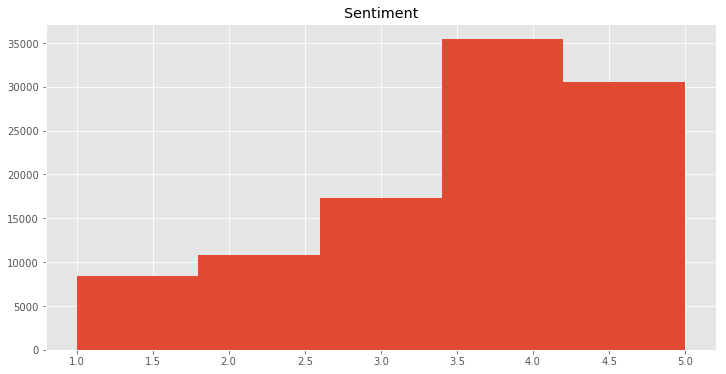

In [6]:
train_set.hist(column='Sentiment', bins=5, figsize=(12, 6))
plt.show()

In [7]:
Y_train = train_set['Sentiment']
Y_train_categorical = np_utils.to_categorical(Y_train)[:, 1:]

In [8]:
Y_train_counts = train_set['Sentiment'].value_counts()[[1, 2, 3, 4, 5]]
Y_train_counts

1     8457
2    10798
3    17340
4    35432
5    30517
Name: Sentiment, dtype: int64

In [9]:
Y_train_percents = Y_train_counts/Y_train.size
Y_train_percents = Y_train_percents.values
Y_train_percents

array([ 0.08247191,  0.10530114,  0.16909814,  0.34552972,  0.29759908])

# Data Preparation

## Tokenization

### Spacy.io

In [10]:
def remove_character_from_string(s, old_characters_list=['\n', '\t'], new_characters_list=None):
    if not new_characters_list:
        new_characters_list = [' ']*len(old_characters_list)
        
    for old_c, new_c in zip(old_characters_list, new_characters_list):
        s = s.replace(old_c, new_c)
        
    return s

def remove_extra_spaces(s):
    return ' '.join( s.split() )

In [11]:
money_regex = r'\$[0-9.,]+'

def money_regex_replace(s):
    return re.sub(money_regex, ' money_regex ', s)

In [12]:
dots_regex = r'\.[.]+'

def dots_replace(s):
    return re.sub(dots_regex, ' ... ', s)

In [13]:
def clear_string(s, to_lower=True):
    s = remove_character_from_string(s, 
                                     ['\\n', '\\"', '-', '"', "\\", ')', '(', '/'], 
                                     [' ', ' ', ' - ', ' ', '', ' ) ', ' ( ', ' / '])
    s = money_regex_replace(s)
    s = dots_replace(s)
    s = remove_extra_spaces(s)
    s = s.lower() if to_lower else s
    return s

In [14]:
def get_spacy_tokens_objects(s):
    s = clear_string(s, to_lower=False)
    return nlp(s)

def text_from_spacy_tokens(tokens):
    tokens = [token.lower_ for token in tokens]
    return ' '.join(tokens)

# Features

## CountVectorizer

In [15]:
if 1==0:
    train_tokenized_objects = train_set['Text'].apply(get_spacy_tokens_objects)
    test_tokenized_objects = test_set['Text'].apply(get_spacy_tokens_objects)
    
    train_tokenized = train_tokenized_objects.apply(text_from_spacy_tokens)
    test_tokenized = test_tokenized_objects.apply(text_from_spacy_tokens)

In [16]:
def space_tokenizer(s):
    return s.split(' ')

if 1==0:
    count_vectorizer = CountVectorizer(analyzer="word", lowercase=False, tokenizer=space_tokenizer,
                                       ngram_range=(1, 3), min_df=20)
    
    count_vectorizer = count_vectorizer.fit(train_tokenized.values)
    
    train_counts = count_vectorizer.transform(train_tokenized.values)
    test_counts = count_vectorizer.transform(test_tokenized.values)

### Сохранение и загрузка результатов

In [17]:
def save_sparse_csr(filename, array):
    # note that .npz extension is added automatically
    np.savez(filename, data=array.data, indices=array.indices,
             indptr=array.indptr, shape=array.shape)

def load_sparse_csr(filename):
    # here we need to add .npz extension manually
    loader = np.load(filename + '.npz')
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']), shape=loader['shape'])

In [18]:
if 1==0: # Чтобы случайно не запустить и не удалить нужные файлы
    %%time
    save_sparse_csr('train_counts', train_counts)
    save_sparse_csr('test_counts', test_counts)

In [19]:
%%time 
train_counts = load_sparse_csr('train_counts')
test_counts = load_sparse_csr('test_counts')

CPU times: user 858 ms, sys: 282 ms, total: 1.14 s
Wall time: 1.14 s


## Features generating

Для начала достанем слова, которые часто встречаются в некоторой группе, а во всех остальных реже.

In [20]:
ones = Y_train == 1
twos = Y_train == 2
threes = Y_train == 3
fours = Y_train == 4
fives = Y_train == 5

marks = [ones, twos, threes, fours, fives]

def get_word_counts(item):
    word, index = item
    counts_by_marks = [train_counts[mark.values, index] for mark in marks]
    counts_bool = [counts_by_mark.astype(bool).sum() for counts_by_mark in counts_by_marks]
    counts = [counts_by_mark.sum() for counts_by_mark in counts_by_marks]
    return {'index': index, 'token': word, 'counts': counts, 'counts_bool': counts_bool}

### Просчет данных(занимает приличное время ~16 часов)

In [21]:
%%time
if 1==0:
    vocabulary_dict = dict(count_vectorizer.vocabulary_)
    with Pool(24) as p:
        words_counts = p.map(get_word_counts, vocabulary_dict.items())
    
    pd.DataFrame(words_counts).to_csv('words_counts.csv', index=False)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 9.06 µs


### Загрузка уже посчитанных данных

In [22]:
import ast

words_counts_df = pd.read_csv('words_counts.csv', index_col='index')

words_counts_df['counts'] = words_counts_df['counts'].apply(lambda l: ast.literal_eval(l))
words_counts_df['counts_bool'] = words_counts_df['counts_bool'].apply(lambda l: ast.literal_eval(l))

words_counts_df.loc[[0]] = words_counts_df.loc[[0]].fillna('blank_string')
words_counts_df.loc[[168817]] = words_counts_df.loc[[168817]].fillna('nan_value')

### Преобразовние этих расчетов в удобочитаемый вид

In [23]:
def normalize_row(row): # Просто нормализовать ряд
    total = sum(row)
    row_normalized = [item/total for item in row]
    return row_normalized

def get_uniqueness_of_row(row):
    '''В выборке разные классы представленны не в равном проценте. 
    Но, если мы разделим нормализованный ряд на процент класса в выборке, 
    то получим уникальность этого слова для класса, чем дальше от единицы будет это значение,
    тем больше говорит это слово о отзыве.'''
    row_normalized = normalize_row(row)
    return [value/coef for value, coef in zip(row_normalized, Y_train_percents)]

words_counts_df['counts_sum'] = words_counts_df['counts'].apply(sum)
words_counts_df['counts_bool_sum'] = words_counts_df['counts_bool'].apply(sum)
words_counts_df['counts_percentage'] = words_counts_df['counts'].apply(normalize_row)
words_counts_df['counts_bool_percentage'] = words_counts_df['counts_bool'].apply(normalize_row)
words_counts_df['counts_uniqueness'] = words_counts_df['counts'].apply(get_uniqueness_of_row)
words_counts_df['counts_bool_uniqueness'] = words_counts_df['counts_bool'].apply(get_uniqueness_of_row)

In [24]:
for i in range(5):
    lambd = lambda l: l[i]
    
    words_counts_df['counts_'+str(i+1)] = words_counts_df['counts'].apply(lambd)
    words_counts_df['counts_bool_'+str(i+1)] = words_counts_df['counts_bool'].apply(lambd)
    words_counts_df['counts_percentage_'+str(i+1)] = words_counts_df['counts_percentage'].apply(lambd)
    words_counts_df['counts_bool_percentage_'+str(i+1)] = words_counts_df['counts_bool_percentage'].apply(lambd)
    words_counts_df['counts_uniqueness_'+str(i+1)] = words_counts_df['counts_uniqueness'].apply(lambd)
    words_counts_df['counts_bool_uniqueness_'+str(i+1)] = words_counts_df['counts_bool_uniqueness'].apply(lambd)

del words_counts_df['counts_percentage']
del words_counts_df['counts_bool_percentage']
del words_counts_df['counts']
del words_counts_df['counts_bool']
del words_counts_df['counts_uniqueness']
del words_counts_df['counts_bool_uniqueness']

#### bool_uniqueness

### Примеры того, как можно отбирать фичи

In [25]:
pd.set_option('display.max_rows', 25)
columns_to_display = ['token', 'counts_bool_sum', 'counts_bool_uniqueness_1', 'counts_bool_uniqueness_2',
                      'counts_bool_uniqueness_3', 'counts_bool_uniqueness_4', 'counts_bool_uniqueness_5']

In [26]:
delta = 0.03
mask_stopwords = ((words_counts_df['counts_bool_uniqueness_1']>1-delta) &
                  (words_counts_df['counts_bool_uniqueness_1']<1+delta) &
                  (words_counts_df['counts_bool_uniqueness_2']>1-delta) &
                  (words_counts_df['counts_bool_uniqueness_2']<1+delta) &
                  (words_counts_df['counts_bool_uniqueness_3']>1-delta) &
                  (words_counts_df['counts_bool_uniqueness_3']<1+delta) &
                  (words_counts_df['counts_bool_uniqueness_4']>1-delta) &
                  (words_counts_df['counts_bool_uniqueness_4']<1+delta) &
                  (words_counts_df['counts_bool_uniqueness_5']>1-delta) &
                  (words_counts_df['counts_bool_uniqueness_5']<1+delta))
tokens_stopwords = words_counts_df[mask_stopwords]
tokens_stopwords[columns_to_display]

,token,counts_bool_sum,counts_bool_uniqueness_1,counts_bool_uniqueness_2,counts_bool_uniqueness_3,counts_bool_uniqueness_4,counts_bool_uniqueness_5
index,,,,,,,
133748,i,87847,1.005948,1.003525,1.008902,1.000206,0.991807
52330,as,40969,1.003613,1.013425,1.022694,0.995973,0.986029
233105,the,91891,1.005882,0.997600,1.002021,1.000281,0.997745
58358,be,92073,1.006527,0.996865,1.001068,1.000316,0.998327
42123,and,90793,1.005760,0.987803,0.996032,1.001731,1.002964
109262,for,75969,1.011123,1.015298,1.021079,1.000170,0.979330
184908,open,9231,1.004862,0.981446,0.985301,1.009536,1.002498
188973,out just,95,1.021081,0.999639,0.995996,0.974857,1.025753
176240,of,81067,0.990315,0.997488,1.011724,1.006388,0.989494


In [27]:
mask = ((words_counts_df['counts_bool_uniqueness_2']<words_counts_df['counts_bool_uniqueness_1']) &
        (words_counts_df['counts_bool_uniqueness_3']<words_counts_df['counts_bool_uniqueness_1']) &
        (words_counts_df['counts_bool_uniqueness_4']<words_counts_df['counts_bool_uniqueness_1']) &
        (words_counts_df['counts_bool_uniqueness_5']<words_counts_df['counts_bool_uniqueness_1']) &
        (words_counts_df['counts_bool_sum']>100))
tokens_masked = words_counts_df[mask].copy()
tokens_masked.sort_values('counts_bool_uniqueness_1', ascending=False, inplace=True)
tokens_masked[columns_to_display].head(10)

,token,counts_bool_sum,counts_bool_uniqueness_1,counts_bool_uniqueness_2,counts_bool_uniqueness_3,counts_bool_uniqueness_4,counts_bool_uniqueness_5
index,,,,,,,
275858,will never return,107,10.198884,1.331295,0.000000,0.027048,0.031404
19680,. never again,107,9.292317,1.153789,0.276342,0.135239,0.062808
271301,we will never,133,8.752125,1.570862,0.133392,0.108801,0.176854
33523,a refund,166,8.692262,1.029749,0.284999,0.156909,0.242908
131907,horrible experience,129,8.365545,1.030636,0.504271,0.089740,0.286531
279785,worst,228,8.296285,1.707717,0.311249,0.152321,0.103165
275854,will never go,367,8.292807,1.190306,0.273933,0.134059,0.329613
141800,incompetent,113,8.262400,1.596769,0.261669,0.256116,0.059473
169520,never again,219,8.194294,1.517717,0.324040,0.198227,0.138091


In [28]:
mask = (words_counts_df['counts_bool_sum']>100) & (words_counts_df['counts_bool_uniqueness_1']>1)

tokens_masked = words_counts_df[mask].copy()
tokens_masked['difference'] = tokens_masked['counts_bool_uniqueness_1'] - tokens_masked['counts_bool_uniqueness_2']
tokens_masked.sort_values('counts_bool_uniqueness_2', ascending=True, inplace=True)
tokens_masked[columns_to_display].head(10)

,token,counts_bool_sum,counts_bool_uniqueness_1,counts_bool_uniqueness_2,counts_bool_uniqueness_3,counts_bool_uniqueness_4,counts_bool_uniqueness_5
index,,,,,,,
850,! not only,124,1.857915,0.076585,0.286148,0.653508,1.896901
32,! ! (,116,1.045288,0.081867,0.509804,0.823324,1.795983
272643,what make it,116,1.045288,0.081867,1.070588,1.247460,0.984894
830,! my wife,107,1.019888,0.088753,0.331611,0.973718,1.727219
69239,beer from,113,1.287647,0.168081,0.523339,0.998851,1.486825
177188,of dog,104,1.282488,0.182626,0.625490,0.807011,1.647803
261017,treat . i,102,1.188759,0.186207,0.811688,1.248438,1.054188
142470,installation,101,2.401057,0.188051,0.234207,0.573090,1.829826
117294,gift .,143,1.017511,0.199229,0.372193,1.072641,1.550873


#### Фичи

In [29]:
def get_tokens_masked(n_normal, percentage_normal, n_other, percentage_other):
    tokens_masked = []
    
    for i in range(1, 6):
        column_name = 'counts_bool_uniqueness_{}'.format(i)
        mask =((words_counts_df[column_name] >= words_counts_df['counts_bool_uniqueness_1']) &
               (words_counts_df[column_name] >= words_counts_df['counts_bool_uniqueness_2']) &
               (words_counts_df[column_name] >= words_counts_df['counts_bool_uniqueness_3']) &
               (words_counts_df[column_name] >= words_counts_df['counts_bool_uniqueness_4']) &
               (words_counts_df[column_name] >= words_counts_df['counts_bool_uniqueness_5']) &
               (words_counts_df['counts_bool_sum'] > n_normal) &
               (words_counts_df[column_name] > 1))

        token_masked = words_counts_df[mask].copy()
        token_masked.sort_values(column_name, ascending=False, inplace=True)
        tokens_masked.append(token_masked.iloc[:int(token_masked.shape[0]*percentage_normal)])
    
    for i in range(1, 6):
        column_name = 'counts_bool_uniqueness_{}'.format(i)
        mask =((words_counts_df[column_name] >= words_counts_df['counts_bool_uniqueness_1']) &
               (words_counts_df[column_name] >= words_counts_df['counts_bool_uniqueness_2']) &
               (words_counts_df[column_name] >= words_counts_df['counts_bool_uniqueness_3']) &
               (words_counts_df[column_name] >= words_counts_df['counts_bool_uniqueness_4']) &
               (words_counts_df[column_name] >= words_counts_df['counts_bool_uniqueness_5']) &
               (words_counts_df['counts_bool_sum'] > n_other) &
               (words_counts_df[column_name] > 1))

        token_masked = words_counts_df[mask].copy()
        token_masked.sort_values(column_name, ascending=False, inplace=True)
        tokens_masked.append(token_masked.iloc[:int(token_masked.shape[0]*percentage_other)])
    
    return tokens_masked

In [30]:
tokens_masked = get_tokens_masked(60, 0.90, 20, 0.60)
tokens_indexes = np.concatenate([tokens.index for tokens in tokens_masked])

print(len(tokens_indexes), len(np.unique(tokens_indexes)))

features_tokens_indexes = np.unique(tokens_indexes)

178721 147792


#### Множества(train, test, validation)

In [31]:
train_features = train_counts[:, features_tokens_indexes].astype(bool).astype(int)
test_features = test_counts[:, features_tokens_indexes].astype(bool).astype(int)

In [32]:
x_train, x_validation, y_train, y_validation = train_test_split(train_features, Y_train_categorical,
                                                                test_size=0.1, random_state=42)
x_test = test_features

# Model

### batch_generator

In [33]:
def batch_generator(X, Y, batch_size, shuffle=False):
    number_of_batches, counter, shuffle_index = X.shape[0]//batch_size, 0, np.arange(Y.shape[0])
    
    if shuffle:
        np.random.shuffle(shuffle_index)
    
    X, Y =  X[shuffle_index], Y[shuffle_index]
    
    while True:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch, Y_batch = X[index_batch].toarray(), Y[index_batch]
        
        counter += 1
        yield X_batch, Y_batch
        
        if counter == number_of_batches:
            if shuffle:
                np.random.shuffle(shuffle_index)
            counter=0

### model architecture

In [34]:
def get_nn_model(*, path_to_hdf5=False, input_dim=None):
    input_dim = (x_train.shape[1],) if not input_dim else input_dim
    
    model = Sequential()
    
    model.add(Dropout(0.5, input_shape=input_dim))
    model.add(Dense(20, activation='sigmoid', init='he_normal'))
    model.add(Dropout(0.5))
    
    model.add(Dense(5, activation='softmax', init='he_normal'))
    
    if path_to_hdf5:
        model.load_weights(path_to_hdf5)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    return model

filepath="weights_{epoch:02d}_{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_acc', patience=5, mode='max')
callbacks_list = [checkpoint, early_stopping]

### training

In [34]:
batch_size = 1000
samples_per_epoch = batch_size*(x_train.shape[0] // batch_size)
nb_val_samples = batch_size*(x_validation.shape[0] // batch_size)
input_dim=(x_train.shape[1], )

model = get_nn_model(input_dim=input_dim)
history = model.fit_generator(generator=batch_generator(x_train, y_train, batch_size, shuffle=True),
                              samples_per_epoch=samples_per_epoch,
                              validation_data=batch_generator(x_validation, y_validation, batch_size, shuffle=False),
                              nb_val_samples=nb_val_samples,
                              nb_epoch=30, verbose=2, callbacks=callbacks_list)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dropout_1 (Dropout)              (None, 147792)        0           dropout_input_1[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 20)            2955860     dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 20)            0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 5)             105         dropout_2[0][0]                  
Total params: 2,955,965
Trainable params: 2,955,965
Non-trainable params: 0
_______________

In [35]:
model = get_nn_model(path_to_hdf5="weights_08_0.633.hdf5", input_dim=(x_train.shape[1], ))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dropout_1 (Dropout)              (None, 147792)        0           dropout_input_1[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 20)            2955860     dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 20)            0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 5)             105         dropout_2[0][0]                  
Total params: 2,955,965
Trainable params: 2,955,965
Non-trainable params: 0
_______________

# Ответ

In [36]:
def predict_generator(model, x_test):
    results = [model.predict(row.toarray()) for row in x_test]
    results = [np.argmax(answer_categorical[0])+1 for answer_categorical in results]
    return results

test_set['Sentiment'] = predict_generator(model, x_test)
test_set[['Sentiment']].to_csv('ans.csv')